# Previsão do Valor de Aluguel

Valor do aluguel na cidade de São Paulo
A base de dados utilizada nesse projeto foi retirada do GitHub de Luiz Armesto, onde ele descreve como foi feita a captação dos dados.

O dataset contém dezenas de milhares de apartamentos disponíveis para locação na cidade de São Paulo.

## Imports

In [226]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.style.use('fivethirtyeight')

from scipy import stats
from scipy.stats import skew, kurtosis

import warnings
from IPython.display import Image

from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn import metrics
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb

warnings.filterwarnings('ignore')


#pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_columns', None)

### Helper Functions

In [291]:
def calcula_estatistica(data):
    mean= round(np.mean(data),2)
    mode= round(stats.mode(data,)[0][0],2)
    median=round(np.median(data),2)
    var= round(np.var(data),2)
    std= round(np.std(data),2)
    coef_person= round(stats.skew(data),2)
    corf_kurtosis= round(kurtosis(data),2)
    msg= print('Media: {} \nModa: {}\nMediana: {}\nVariância: {}\nDesvio Padrão: {}\nSkew: {}\nKurtosis: {}'.format(mean, mode, median, var, std, coef_person, corf_kurtosis))

    return msg

#Função para calcular performance dos modelos
def ml_error( model_name, y, yhat):
    Rquadrado = metrics.r2_score(y, yhat)
    mae = metrics.mean_absolute_error(y, yhat)
    mape= metrics.mean_absolute_percentage_error(y, yhat)
    rmse= np.sqrt(metrics.mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                        'MAE': mae,
                        'MAPE': mape,
                        'RMSE': rmse,
                        'R': Rquadrado}, index=[0])

### Loading data

In [4]:
# Link do dataset
url = 'https://github.com/LuizArmesto/notebooks/blob/master/regressao_linear/apartamentos_alugar_sao_paulo.csv?raw=true'

data = pd.read_csv(url)

In [5]:
data.head()

,valor,area,quartos,suites,vagas,bairro_id,bairro,cidade,tipo,subtipo,id
0,1600,57,2,0,1,1,VL DA SAUDE,Sao Paulo,1,3,9165861
1,5600,143,4,1,2,2,ITAIM BIBI,Sao Paulo,1,3,8657016
2,3000,140,3,1,1,3,BROOKLIN,Sao Paulo,1,2,9245580
3,4000,70,2,1,1,4,CAMPO BELO,Sao Paulo,1,2,8788916
4,2500,80,2,1,2,5,PERDIZES,Sao Paulo,1,1,9257792


## Description of the data

### Data Dimension

In [6]:
print(f'Numero de linhas do DataFrame: {data.shape[0]}')
print(f'Numero de Colunas do DataFrame: {data.shape[1]}')

Numero de linhas do DataFrame: 28879
Numero de Colunas do DataFrame: 11


### Missing Data

In [7]:
data.isna().sum()

valor        0
area         0
quartos      0
suites       0
vagas        0
bairro_id    0
bairro       0
cidade       0
tipo         0
subtipo      0
id           0
dtype: int64

### Data Types

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28879 entries, 0 to 28878
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   valor      28879 non-null  int64 
 1   area       28879 non-null  int64 
 2   quartos    28879 non-null  int64 
 3   suites     28879 non-null  int64 
 4   vagas      28879 non-null  int64 
 5   bairro_id  28879 non-null  int64 
 6   bairro     28879 non-null  object
 7   cidade     28879 non-null  object
 8   tipo       28879 non-null  int64 
 9   subtipo    28879 non-null  int64 
 10  id         28879 non-null  int64 
dtypes: int64(9), object(2)
memory usage: 2.4+ MB


In [10]:
data.sample(1).T

,17018
valor,2300
area,74
quartos,2
suites,0
vagas,1
bairro_id,6
bairro,JD PAULISTA
cidade,Sao Paulo
tipo,1
subtipo,1


### Descriptive Statistical

In [11]:
num_atributes = data.select_dtypes(include=['int64', 'float64'])
cat_atributes = data.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### Numerical Atributes

In [12]:
pd.set_option('float_format', '{:.3f}'.format)

#Central Tendency - mean - median
ct1 = pd.DataFrame(num_atributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_atributes.apply(np.median)).T

#Dispersion - STD, min, max, range, sken, Kurtosis
d1 = pd.DataFrame(num_atributes.apply(np.std)).T
d2 = pd.DataFrame(num_atributes.apply(min)).T
d3 = pd.DataFrame(num_atributes.apply(max)).T
d4 = pd.DataFrame(num_atributes.apply(lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_atributes.apply(lambda x: x.skew() )).T
d6 = pd.DataFrame(num_atributes.apply(lambda x: x.kurtosis() )).T

#Concatenate

m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,valor,500.000,10000.000,9500.000,3482.065,2800.000,2056.178,1.302,1.156
1,area,0.000,694.000,694.000,98.545,80.000,57.917,2.040,7.302
2,quartos,0.000,8.000,8.000,2.336,2.000,0.874,0.055,-0.629
3,suites,0.000,5.000,5.000,0.881,1.000,0.918,1.220,1.375
4,vagas,0.000,2000.000,2000.000,1.651,1.000,16.250,119.609,14367.592
5,bairro_id,1.000,449.000,448.000,46.370,29.000,58.711,2.893,10.823
6,tipo,1.000,1.000,0.000,1.000,1.000,0.000,0.000,0.000
7,subtipo,1.000,4.000,3.000,1.976,2.000,1.178,0.879,-0.797
8,id,45429.000,9645240.000,9599811.000,8333660.528,8929920.000,1544781.832,-2.187,5.821


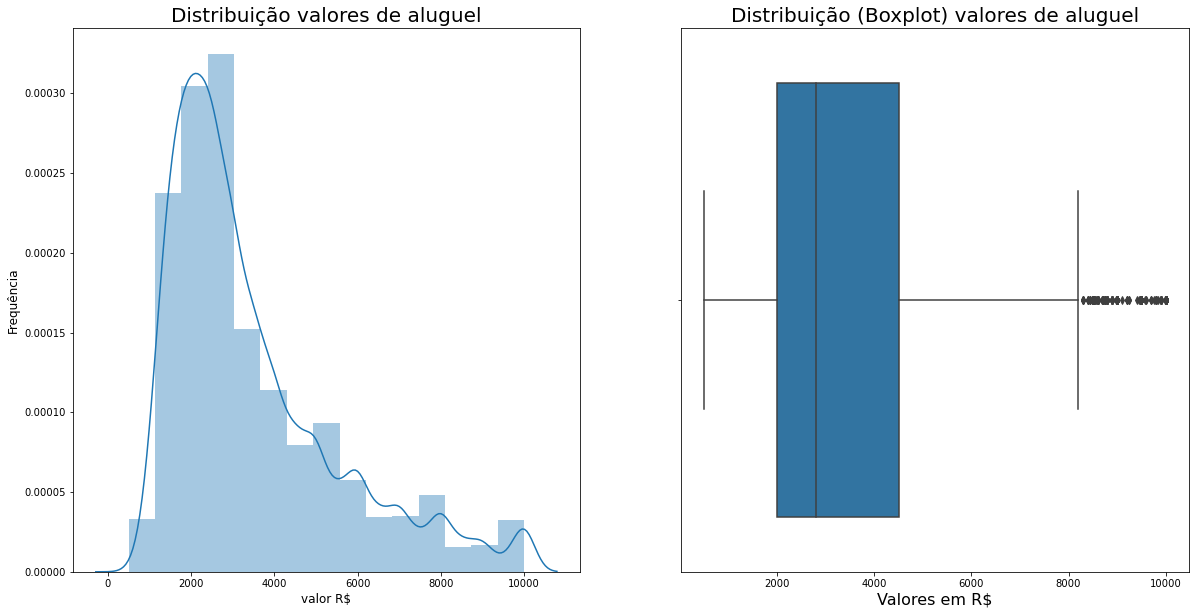

In [13]:
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
sns.distplot(data['valor'], vertical=False, bins=15)
plt.xlabel('valor R$', fontsize= 12)
plt.ylabel('Frequência', fontsize= 12)
plt.title(f'Distribuição valores de aluguel', fontsize=20)

plt.subplot(1,2,2)
sns.boxplot(data.valor);
plt.title(f'Distribuição (Boxplot) valores de aluguel', fontsize=20)
plt.xlabel('Valores em R$', fontsize=16);



### Categorical Atributes

In [14]:
cat_atributes.apply(lambda x: x.unique().shape[0])

bairro    449
cidade      1
dtype: int64

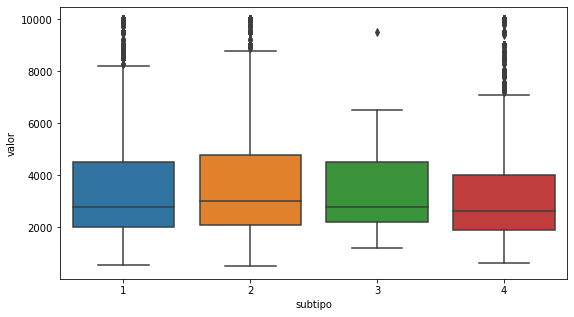

In [15]:
plt.figure(figsize = (20, 5))

plt.subplot(1, 2, 1)
sns.boxplot(x='subtipo' , y= 'valor', data=data);


## Feature Engineering

### Mapa Mental de Hipóteses

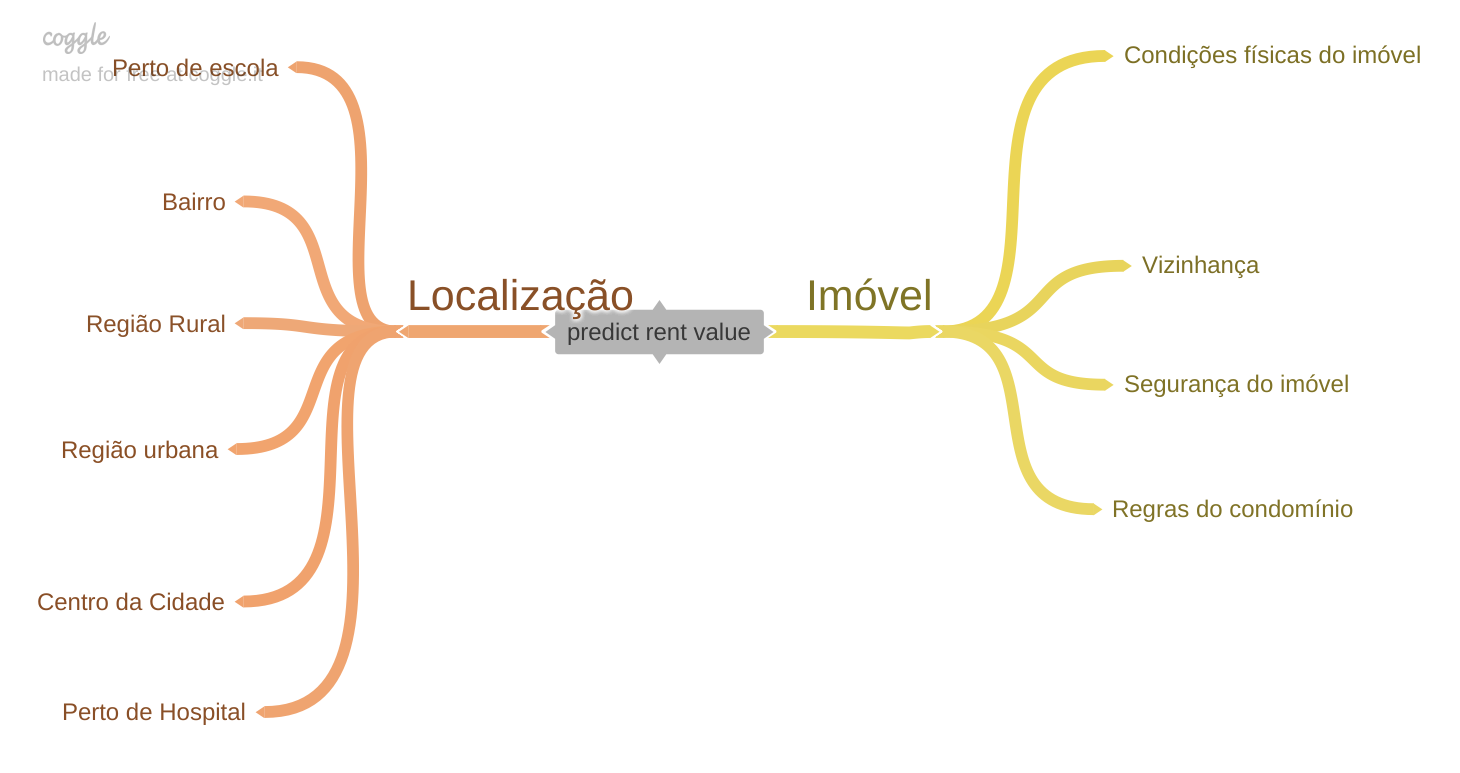

In [83]:
Image('img/predict_rent_value.png', )

#### Criação de Hipóteses

#### As Hipóteses Imovel 
- H1: Imoveis com mais de 100 metros quadrados custa na media 50% mais caro do que imoveis com menos de 100m.
- H2: Imoveis com 2 vagas de Estacionamento custa 40% mais na media do que imovel com 1 vaga.
- H3: Imoveis que possui mais de 1 suite são 20% mais caro na media do que imovel com 1 suites.
- H4: Imoveis com preço abaixo da media do bairro seria uma boa oportunidade de aluguel.
- H5: Imoveis acima do preço medio da região, na media tem mais de 1 vaga de estacionamento e mais 1 uma suite.

#### As Hipóteses Localização

- H1: Na media valor de aluguel de Imoveis perto de escola é 30% mais caro dos mais distante.
- H2: Na media valor de aluguel de Imoveis em zona rural é 20% mais barato
- H3: Na media valor de aluguel de imoveis no centro da Cidade é 50% mais caro do que imoveis na região rural.

#### Lista Final de Hipóteses

##### Criterio de priorização:

No Metodo Crisp vamos priorizar os dados que temos para selecionar as Hipóteses, caso la na frente o modelo estiver performado mal, coletaremos os dados necessario para respondermos as demais hipóteses e tentarmos melhorar o modelo

- H1: Imoveis com mais de 100 metros quadrados custa na media 50% mais caro do que imoveis com menos de 100m.
- H2: Imoveis com 2 vagas de Estacionamento custa 40% mais na media do que imovel com 1 vaga.
- H3: Imoveis que possui mais de 1 suite são 20% mais caro na media do que imovel com 1 suites.
- H4: Imoveis com preço abaixo da media do bairro seria uma boa oportunidade de aluguel.
- H5: Imoveis acima do preço medio da região, na media tem mais de 1 vaga de estacionamento e mais 1 uma suite.

In [16]:
df1 = data.copy()

### Feature Engineering

Até o momento não identifiquei a necessidade de derivar variaveis, caso até o final identifique alguma oportunidade estarei criando a feature.

## Variable filtering

In [47]:
df2 = df1.copy()
df2.head()

,valor,area,quartos,suites,vagas,bairro_id,bairro,cidade,tipo,subtipo,id
0,1600,57,2,0,1,1,VL DA SAUDE,Sao Paulo,1,3,9165861
1,5600,143,4,1,2,2,ITAIM BIBI,Sao Paulo,1,3,8657016
2,3000,140,3,1,1,3,BROOKLIN,Sao Paulo,1,2,9245580
3,4000,70,2,1,1,4,CAMPO BELO,Sao Paulo,1,2,8788916
4,2500,80,2,1,2,5,PERDIZES,Sao Paulo,1,1,9257792


### Analisando e resolvendo algumas incosistencias

### Coluna Area

Verificando a coluna area de forma unificado, identificamos alguns valores fora do comum e iremos investigar.

In [48]:
df2['area'].sort_values().unique()

array([  0,   1,  10,  15,  18,  19,  20,  22,  23,  24,  25,  26,  27,
        28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
        41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
        54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
       106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
       119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
       132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144,
       145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157,
       158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170,
       171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
       184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 19

In [49]:
#Primeira inconsistencia seria imoveis com metragem = 0

df2[df2['area'] == 0]

,valor,area,quartos,suites,vagas,bairro_id,bairro,cidade,tipo,subtipo,id
10285,1700,0,3,1,2,16,MOOCA,Sao Paulo,1,2,9575472
20467,1400,0,3,0,1,73,FREGUESIA DO Ó,Sao Paulo,1,2,9604609
20780,3500,0,1,0,1,3,BROOKLIN,Sao Paulo,1,2,9592144
23224,2900,0,1,0,1,27,AV PAULISTA,Sao Paulo,1,2,9592142
28156,1700,0,1,0,0,23,CERQUEIRA CÉSAR,Sao Paulo,1,2,9636363
28168,1100,0,2,1,1,124,VL CARRÃO,Sao Paulo,1,1,9591566
28178,1300,0,2,0,0,55,CAMBUCI,Sao Paulo,1,1,9634200
28191,2500,0,2,0,1,6,JD PAULISTA,Sao Paulo,1,2,9617319
28209,1300,0,1,0,0,8,CONSOLAÇÃO,Sao Paulo,1,1,9591745
28223,2300,0,2,1,2,69,REAL PARQUE,Sao Paulo,1,2,9427670


##### Imoveis com area 0, irei substituir pela media dos imoveis com a mesma quantidade de quartos

In [50]:
area_zero = df2[df2['area'] == 0]
for i in area_zero['quartos'].iteritems():
    quarto= i[1]
    df2['area'].loc[i[0]] = int(df2[df2['quartos'] == quarto]['area'].mean())

#Verificando se ficou algum imovel com area = 0
df2[df2['area'] == 0]

,valor,area,quartos,suites,vagas,bairro_id,bairro,cidade,tipo,subtipo,id


##### Outra incosistencia encontrada são os imoveis com area igual a 10m² e 3 suites, para estes casos irei alterar para 100m²

In [51]:
# Selecionando o apartamento com área 10m² e 3 suítes
area_dez = df2.query("area == 10 & suites == 3")
id = area_dez['id'].values[0]

df2['area'].loc[area_dez.index] = 100

# Mostrando que agora a área dele é 100m²
df2.query(f"id == {id}")

,valor,area,quartos,suites,vagas,bairro_id,bairro,cidade,tipo,subtipo,id
9922,4500,100,3,3,2,2,ITAIM BIBI,Sao Paulo,1,1,9544863


In [52]:
# Mostrando que agora a área dele é 100m²
df2.query(f"id == {id}")

,valor,area,quartos,suites,vagas,bairro_id,bairro,cidade,tipo,subtipo,id
9922,4500,100,3,3,2,2,ITAIM BIBI,Sao Paulo,1,1,9544863


##### Imoveis com area de 1m²

Iremos trocar esse valor pela media das áreas dos apartamentos com as mesmas especificações.

In [53]:
df2[df2['area'] == 1]

,valor,area,quartos,suites,vagas,bairro_id,bairro,cidade,tipo,subtipo,id
28310,1800,1,1,0,1,23,CERQUEIRA CÉSAR,Sao Paulo,1,1,9591743


In [54]:
#Filtrando o imovel com area =1
area_um = df2[df2['area'] == 1]

#Criando o valor que será introduzido no filtro
nova_area = df2.query('quartos == 1 &  suites == 0 & vagas == 1 & bairro == "CERQUEIRA CÉSAR"')['area'].mean()

#Executando a mudança do valor
df2['area'].loc[area_um.index] = nova_area

In [55]:
# Mostrando que agora não temos mais apartamentos com área igual a 1m²
df2[df2['area'] == 1]

,valor,area,quartos,suites,vagas,bairro_id,bairro,cidade,tipo,subtipo,id


##### Imoveis com area de 15m²

In [56]:
#Filtrando os imoveis
area_quinze = df2[df2['area'] == 15]

area_quinze


,valor,area,quartos,suites,vagas,bairro_id,bairro,cidade,tipo,subtipo,id
4806,750,15.000,2,0,1,261,GUAIANAZES,Sao Paulo,1,1,9143698
9547,500,15.000,1,1,0,167,CJ RESID JOSE BONIFACIO,Sao Paulo,1,2,9311617
16479,5000,15.000,4,2,0,167,CJ RESID JOSE BONIFACIO,Sao Paulo,1,1,7903745
22512,1400,15.000,2,0,1,186,ITAQUERA,Sao Paulo,1,1,8362734
26217,750,15.000,2,0,1,261,GUAIANAZES,Sao Paulo,1,1,8594064
26828,850,15.000,2,0,0,167,CJ RESID JOSE BONIFACIO,Sao Paulo,1,1,7862439


##### Vamos avaliar cada imovel com area de 15m² dentro do seu respectivo bairro com as mesmas features e tentarmso identificar alguma inconsistencia

- Imoveis de ITAQUERA

In [57]:
df2.query('quartos == 2 & suites == 0 & vagas ==1 & bairro == "ITAQUERA"')

,valor,area,quartos,suites,vagas,bairro_id,bairro,cidade,tipo,subtipo,id
1881,1000,48.000,2,0,1,186,ITAQUERA,Sao Paulo,1,2,8718975
3914,1000,54.000,2,0,1,186,ITAQUERA,Sao Paulo,1,2,5983685
5917,1500,60.000,2,0,1,186,ITAQUERA,Sao Paulo,1,2,8948548
7003,855,50.000,2,0,1,186,ITAQUERA,Sao Paulo,1,4,9635264
8510,1300,54.000,2,0,1,186,ITAQUERA,Sao Paulo,1,4,9209549
9432,800,48.000,2,0,1,186,ITAQUERA,Sao Paulo,1,1,9460891
12077,1100,50.000,2,0,1,186,ITAQUERA,Sao Paulo,1,2,6630382
15357,750,42.000,2,0,1,186,ITAQUERA,Sao Paulo,1,2,7267750
17823,1200,45.000,2,0,1,186,ITAQUERA,Sao Paulo,1,2,8718994
19972,1000,49.000,2,0,1,186,ITAQUERA,Sao Paulo,1,2,5585799


In [58]:
df2.query('quartos == 2 & suites == 0 & vagas ==1 & bairro == "ITAQUERA"')['area'].describe()

count   18.000
mean    49.333
std     10.134
min     15.000
25%     48.000
50%     50.000
75%     54.750
max     62.000
Name: area, dtype: float64

Podemos ver que todos os imoveis com 2 quartos, 0 suítes, 1 vaga de garagem e localizado em Itaquera, um bairro da periferia da cidade, tem áreas em torno de 50m², mesmo incluindo àquele de área 15m².
Então é o valor da mediana (50m²) que iremos atribuir àquele apartamento com comportamento anômalo.

In [59]:
ita_quinze = area_quinze[area_quinze['bairro'] == 'ITAQUERA']
median= df2.query('quartos == 2 & suites == 0 & vagas ==1 & bairro == "ITAQUERA"')['area'].median()

df2['area'].loc[ita_quinze.index.values[0]] = median


In [66]:
# Mostrando que agora não temos mais aquele apartamento de Itaquera com área 15m²
df2[df2['area'] == 15]

,valor,area,quartos,suites,vagas,bairro_id,bairro,cidade,tipo,subtipo,id
4806,750,15.000,2,0,1,261,GUAIANAZES,Sao Paulo,1,1,9143698
9547,500,15.000,1,1,0,167,CJ RESID JOSE BONIFACIO,Sao Paulo,1,2,9311617
16479,5000,15.000,4,2,0,167,CJ RESID JOSE BONIFACIO,Sao Paulo,1,1,7903745
26217,750,15.000,2,0,1,261,GUAIANAZES,Sao Paulo,1,1,8594064
26828,850,15.000,2,0,0,167,CJ RESID JOSE BONIFACIO,Sao Paulo,1,1,7862439


##### Os dois imoveis de Guaianazes

Temos 2 imoveis com 15m² e dois quatos, vamos investigar, pois pelo tamanho não faz muito sentido.

In [67]:
df2.query('bairro == "GUAIANAZES"')

,valor,area,quartos,suites,vagas,bairro_id,bairro,cidade,tipo,subtipo,id
4806,750,15.000,2,0,1,261,GUAIANAZES,Sao Paulo,1,1,9143698
26217,750,15.000,2,0,1,261,GUAIANAZES,Sao Paulo,1,1,8594064


Neste caso, iremos utilizar o valor da media dos outros bairros que tem a mesma quantidade de quartos, suites, vagas e que estão no mesmo preço, conforme podemos visualizar no codigo abaixo.

In [68]:
df2.query('valor == 750 & quartos == 2 & suites == 0 & vagas == 1')

,valor,area,quartos,suites,vagas,bairro_id,bairro,cidade,tipo,subtipo,id
4806,750,15.000,2,0,1,261,GUAIANAZES,Sao Paulo,1,1,9143698
6067,750,52.000,2,0,1,167,CJ RESID JOSE BONIFACIO,Sao Paulo,1,1,9224408
15094,750,51.000,2,0,1,151,CID LÍDER,Sao Paulo,1,2,8986708
15357,750,42.000,2,0,1,186,ITAQUERA,Sao Paulo,1,2,7267750
19733,750,49.000,2,0,1,151,CID LÍDER,Sao Paulo,1,1,9196090
26217,750,15.000,2,0,1,261,GUAIANAZES,Sao Paulo,1,1,8594064


In [69]:
df2.query('valor == 750 & quartos == 2 & suites == 0 & vagas == 1')['area'].describe()



count    6.000
mean    37.333
std     17.648
min     15.000
25%     21.750
50%     45.500
75%     50.500
max     52.000
Name: area, dtype: float64

In [70]:
#Executando a alteração com a median 45m²

guaia_area_15 = df2.query('bairro == "GUAIANAZES"') #Imoveis a ser alterado
nova_area = df2.query('valor == 750 & quartos == 2 & suites == 0 & vagas == 1')['area'].median() #O valor que sera colocado nos imoveis a ser alterado.

for i in guaia_area_15.index.values:
    df2['area'].loc[i] = nova_area

In [71]:
# Mostrando que agora não temos mais aquele apartamento de Itaquera com área 15m²
bonifacio = df2[df2['area'] == 15]

bonifacio

,valor,area,quartos,suites,vagas,bairro_id,bairro,cidade,tipo,subtipo,id
9547,500,15.000,1,1,0,167,CJ RESID JOSE BONIFACIO,Sao Paulo,1,2,9311617
16479,5000,15.000,4,2,0,167,CJ RESID JOSE BONIFACIO,Sao Paulo,1,1,7903745
26828,850,15.000,2,0,0,167,CJ RESID JOSE BONIFACIO,Sao Paulo,1,1,7862439


Agora temos os imoveiso do Residencial Jose Bonifacio, note que os tres são do mesmo conjunto, localizado na pereferia da Cidade. Entretanto os tres tem especificações diferentes, sendo que um deles tem o valor do aluguel bem acima do demais da região.

O primeiro que o luguel custa 500,00 vamos deixar do jeito que esta, pois acredito que faça sentido, mesmo com 1 quarto e 1 suite, essa area não seria um problema se ele for uma Kitnet, como não temos como saber, deixaremos assim e um dos problemas ja esta resolvido

In [72]:
#Vamos retirar o possivel kitnet.
bonifacio.drop(bonifacio[bonifacio['quartos'] == 1].index, inplace=True)

In [73]:
# Mostrando os apartamentos do Cj. Residencial José Bonifácio que restaram
bonifacio

,valor,area,quartos,suites,vagas,bairro_id,bairro,cidade,tipo,subtipo,id
16479,5000,15.000,4,2,0,167,CJ RESID JOSE BONIFACIO,Sao Paulo,1,1,7903745
26828,850,15.000,2,0,0,167,CJ RESID JOSE BONIFACIO,Sao Paulo,1,1,7862439


Dos dois que sobraram, vamos primeiramente resolver esse de 2 quartos. Utilizaremos o mesmo método que usamos anteriormente naquele de Itaquera.

In [74]:
df2.query('quartos == 2 & bairro == "CJ RESID JOSE BONIFACIO"')

,valor,area,quartos,suites,vagas,bairro_id,bairro,cidade,tipo,subtipo,id
1607,900,46.000,2,1,1,167,CJ RESID JOSE BONIFACIO,Sao Paulo,1,1,9549704
6067,750,52.000,2,0,1,167,CJ RESID JOSE BONIFACIO,Sao Paulo,1,1,9224408
13355,1000,48.000,2,0,1,167,CJ RESID JOSE BONIFACIO,Sao Paulo,1,1,9461047
14988,900,52.000,2,0,1,167,CJ RESID JOSE BONIFACIO,Sao Paulo,1,1,9634765
26828,850,15.000,2,0,0,167,CJ RESID JOSE BONIFACIO,Sao Paulo,1,1,7862439


In [75]:
df2.query('quartos == 2 & bairro == "CJ RESID JOSE BONIFACIO"')['area'].describe()

count    5.000
mean    42.600
std     15.646
min     15.000
25%     46.000
50%     48.000
75%     52.000
max     52.000
Name: area, dtype: float64

In [76]:
jose_2_quartos = bonifacio.query('quartos == 2')
nova_area = df2.query('quartos == 2 & bairro == "CJ RESID JOSE BONIFACIO"')['area'].median()

df2['area'].loc[jose_2_quartos.index.values[0]] = nova_area

# Mostrando que a nova área agora é 48m²
df2.query(f'index == {jose_2_quartos.index.values[0]}')

,valor,area,quartos,suites,vagas,bairro_id,bairro,cidade,tipo,subtipo,id
26828,850,48.000,2,0,0,167,CJ RESID JOSE BONIFACIO,Sao Paulo,1,1,7862439


##### Agora nos resta o ultimo problema.

In [77]:
df2.query('bairro == "CJ RESID JOSE BONIFACIO"').describe()

,valor,area,quartos,suites,vagas,bairro_id,tipo,subtipo,id
count,9.000,9.000,9.000,9.000,9.000,9.000,9.000,9.000,9.000
mean,1288.889,43.111,2.333,0.444,0.667,167.000,1.000,1.111,9116348.111
std,1398.834,16.305,0.866,0.726,0.500,0.000,0.000,0.333,710938.343
min,500.000,15.000,1.000,0.000,0.000,167.000,1.000,1.000,7862439.000
25%,800.000,46.000,2.000,0.000,0.000,167.000,1.000,1.000,9224408.000
50%,900.000,48.000,2.000,0.000,1.000,167.000,1.000,1.000,9461047.000
75%,900.000,52.000,3.000,1.000,1.000,167.000,1.000,1.000,9549704.000
max,5000.000,56.000,4.000,2.000,1.000,167.000,1.000,2.000,9634765.000


O valor do aluguel desse imovel é bem acima dos demais da mesma região, como pode ver na tabela acima. 

In [78]:
jose_4_quartos = bonifacio.query('quartos == 4')
jose_4_quartos

,valor,area,quartos,suites,vagas,bairro_id,bairro,cidade,tipo,subtipo,id
16479,5000,15.000,4,2,0,167,CJ RESID JOSE BONIFACIO,Sao Paulo,1,1,7903745


Os valores de quarto, suites, valor aluguel estão todos acima da media e mediana e alguns estão acima da max da região, neste caso preferi excluir esse imovel do dataset pois é um imovel que foge completamente do padrão dos demais imoveis vizinhos.

In [79]:
df2 = df2.drop(jose_4_quartos.index.values[0]).reset_index().drop('index', axis=1)

### Coluna Quartos

Podemos notar que todos os imoveis com 2 quartos, 0 suites e 1 vaga de estacionamento, localizado no bairro Itaquera, temos uma mediana de area de 50m², mesmo incluindo o imovel com 15m².

Neste caso vamos alterar o valor da area desse imovel para 50m²

In [80]:
df3 = df2.copy()

#### Avaliando a variavel quarto, notamos que existem imoveis com nenhum quarto, podemos deduzir que poderia ser Kitnet, onde quarto e sala se fundem.

In [84]:
df3['quartos'].unique()

array([2, 4, 3, 1, 6, 5, 0, 8])

In [85]:
#Imoveis com 0 quarto

quarto_zero = df3[df3['quartos'] == 0]

quarto_zero

,valor,area,quartos,suites,vagas,bairro_id,bairro,cidade,tipo,subtipo,id
3758,2500,122.000,0,0,0,110,VL STA CATARINA,Sao Paulo,1,1,8680004
6743,2670,45.000,0,0,0,41,JARDINS,Sao Paulo,1,1,7801228
8279,8500,180.000,0,0,0,41,JARDINS,Sao Paulo,1,1,9624989
17888,2400,100.000,0,0,2,16,MOOCA,Sao Paulo,1,1,9587770
18996,700,30.000,0,0,0,42,BELA VISTA,Sao Paulo,1,1,9576508
21224,8000,138.000,0,0,2,3,BROOKLIN,Sao Paulo,1,1,9067825
22119,800,40.000,0,0,0,51,STA CECÍLIA,Sao Paulo,1,1,9610085
22726,2800,113.000,0,0,0,49,HIGIENÓPOLIS,Sao Paulo,1,1,7806634


Avaliando os imoveis com quarto = 0 apenas um tem área de 30m2, os demais tem uma área na media dos demais, sendo uma area grande para considerarmos um Kitnet, o que nos leva crer que pode ser um erro de digitação do dataset.

Para este caso vou considerar os imovel com 30m² como Kitnet e os demais vou estimar o numero de quarto através da media do tamanho dos demais imoveis.

In [86]:
novo_data = quarto_zero[quarto_zero['area'] != 30]
novo_data

,valor,area,quartos,suites,vagas,bairro_id,bairro,cidade,tipo,subtipo,id
3758,2500,122.000,0,0,0,110,VL STA CATARINA,Sao Paulo,1,1,8680004
6743,2670,45.000,0,0,0,41,JARDINS,Sao Paulo,1,1,7801228
8279,8500,180.000,0,0,0,41,JARDINS,Sao Paulo,1,1,9624989
17888,2400,100.000,0,0,2,16,MOOCA,Sao Paulo,1,1,9587770
21224,8000,138.000,0,0,2,3,BROOKLIN,Sao Paulo,1,1,9067825
22119,800,40.000,0,0,0,51,STA CECÍLIA,Sao Paulo,1,1,9610085
22726,2800,113.000,0,0,0,49,HIGIENÓPOLIS,Sao Paulo,1,1,7806634


Vamos agora estimar o número de quartos atraves do tamanho (area) do imovel observando os demais dados.

In [87]:
for i in novo_data['area'].iteritems():
    a = i[1]
    df3['quartos'].loc[i[0]] = int(df3[df3['area'] == a]['quartos'].max())

In [88]:
# Mostrando que agora temos apenas aquele kitinet com zero quartos
df3[(df3['quartos'] == 0)]

,valor,area,quartos,suites,vagas,bairro_id,bairro,cidade,tipo,subtipo,id
18996,700,30.000,0,0,0,42,BELA VISTA,Sao Paulo,1,1,9576508


## Exploraty data analysis

In [89]:
df4 = df3.copy()

### Analise Univariada

##### Response Variable

Media: 3482.01 
Moda: 2500
Mediana: 2800.0
Variância: 4227933.28
Desvio Padrão: 2056.19
Skew: 1.3
Kurtosis: 1.16


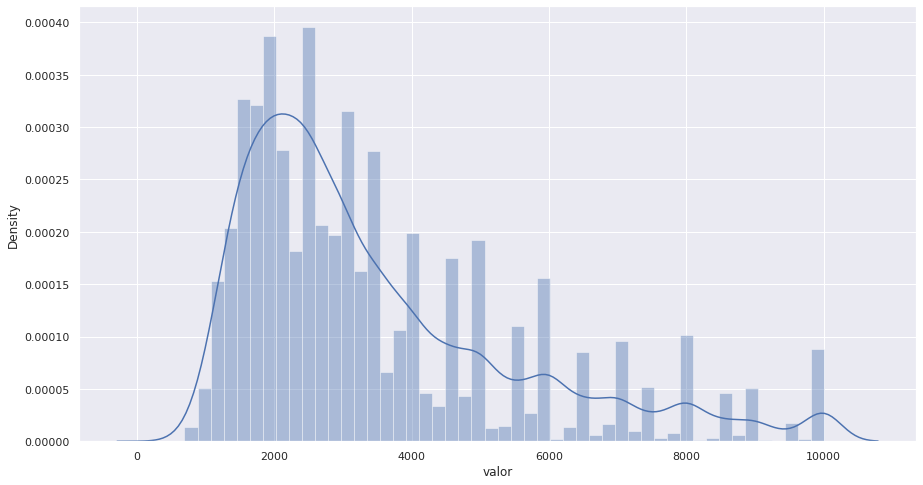

In [90]:
sns.set(rc= {'figure.figsize': (15,8)})
sns.distplot(df4['valor'])
calcula_estatistica(df4['valor'])


##### Numerical Variable

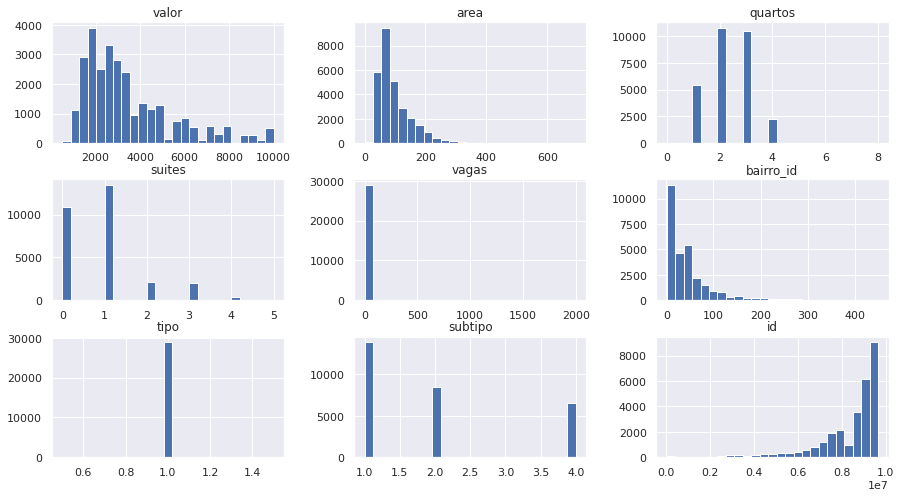

In [91]:
num_atributes.hist(bins=25);

##### Categorical Variable

##### Variavel Quarto

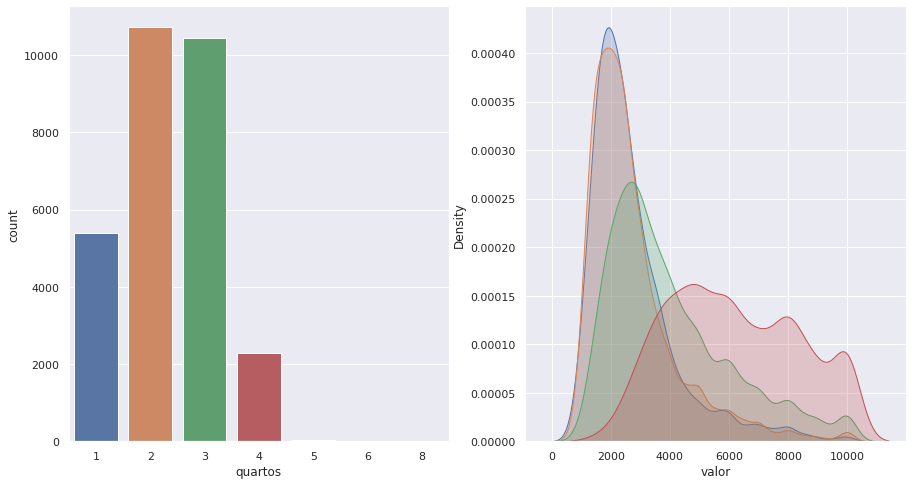

In [92]:



aux = df4[df4['quartos'] > 0 ]
plt.subplot(1, 2, 1)
sns.countplot(aux['quartos'])

plt.subplot(1,2,2)
sns.kdeplot(aux[aux['quartos'] == 1]['valor'], label= 1, shade=True)
sns.kdeplot(aux[aux['quartos'] == 2]['valor'], label= 2, shade=True)
sns.kdeplot(aux[aux['quartos'] == 3]['valor'], label= 3, shade=True)
sns.kdeplot(aux[aux['quartos'] == 4]['valor'], label= 4, shade=True);

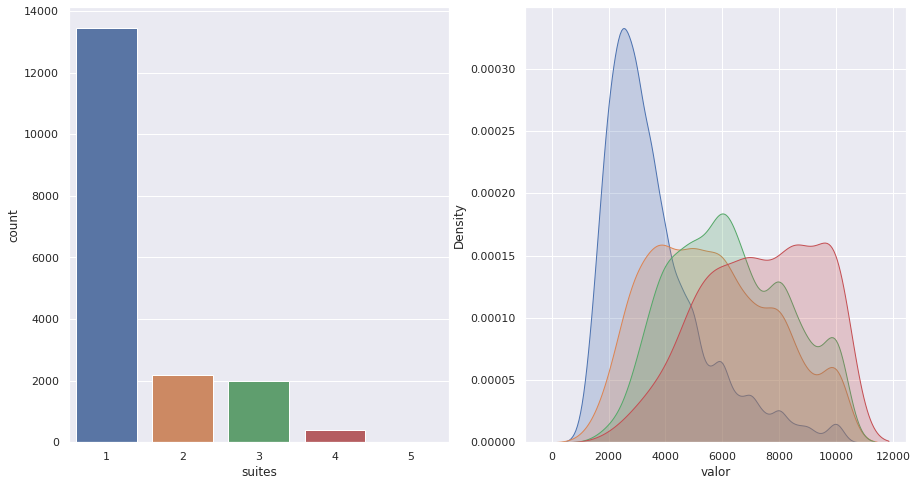

In [93]:
aux = df4[df4['suites'] > 0 ]
plt.subplot(1, 2, 1)
sns.countplot(aux['suites'])

plt.subplot(1,2,2)
sns.kdeplot(aux[aux['suites'] == 1]['valor'], label= 1, shade=True)
sns.kdeplot(aux[aux['suites'] == 2]['valor'], label= 2, shade=True)
sns.kdeplot(aux[aux['suites'] == 3]['valor'], label= 3, shade=True)
sns.kdeplot(aux[aux['suites'] == 4]['valor'], label= 4, shade=True);

##### Variavel Subtipo

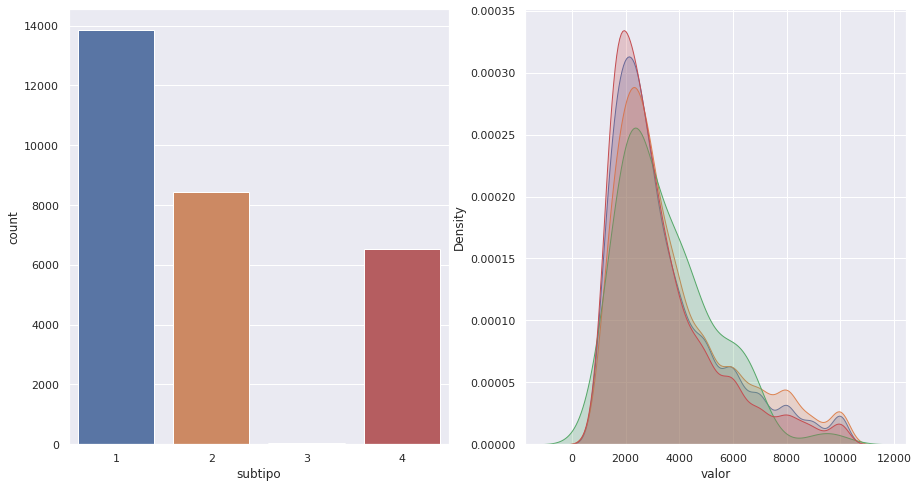

In [94]:
aux = df4[df4['subtipo'] > 0 ]
plt.subplot(1, 2, 1)
sns.countplot(aux['subtipo'])

plt.subplot(1,2,2)
sns.kdeplot(aux[aux['subtipo'] == 1]['valor'], label= 1, shade=True)
sns.kdeplot(aux[aux['subtipo'] == 2]['valor'], label= 2, shade=True)
sns.kdeplot(aux[aux['subtipo'] == 3]['valor'], label= 3, shade=True)
sns.kdeplot(aux[aux['subtipo'] == 4]['valor'], label= 4, shade=True);

In [95]:
df4['subtipo'].value_counts()

1    13849
2     8424
4     6547
3       58
Name: subtipo, dtype: int64

Variavel Vagas

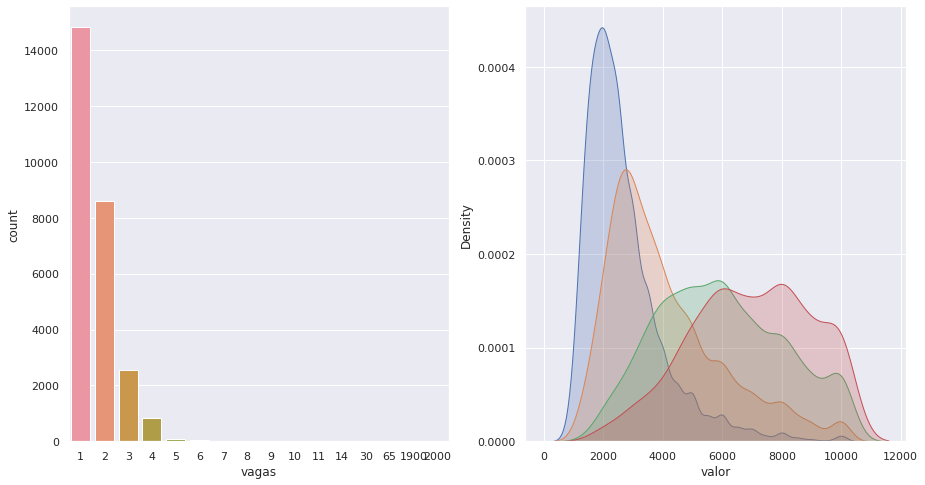

In [96]:
aux = df4[df4['vagas'] > 0 ]
plt.subplot(1, 2, 1)
sns.countplot(aux['vagas'])

plt.subplot(1,2,2)
sns.kdeplot(aux[aux['vagas'] == 1]['valor'], label= 1, shade=True)
sns.kdeplot(aux[aux['vagas'] == 2]['valor'], label= 2, shade=True)
sns.kdeplot(aux[aux['vagas'] == 3]['valor'], label= 3, shade=True)
sns.kdeplot(aux[aux['vagas'] == 4]['valor'], label= 4, shade=True);

### Analise Bivariada

- H1: Imoveis com mais de 100 metros quadrados custa na media 50% mais caro do que imoveis com menos de 100m.

Hipotese Verdadeira, imoveis com mais de 100m² custa na media 108.06% a mais do que imovel abaixo de 100m.


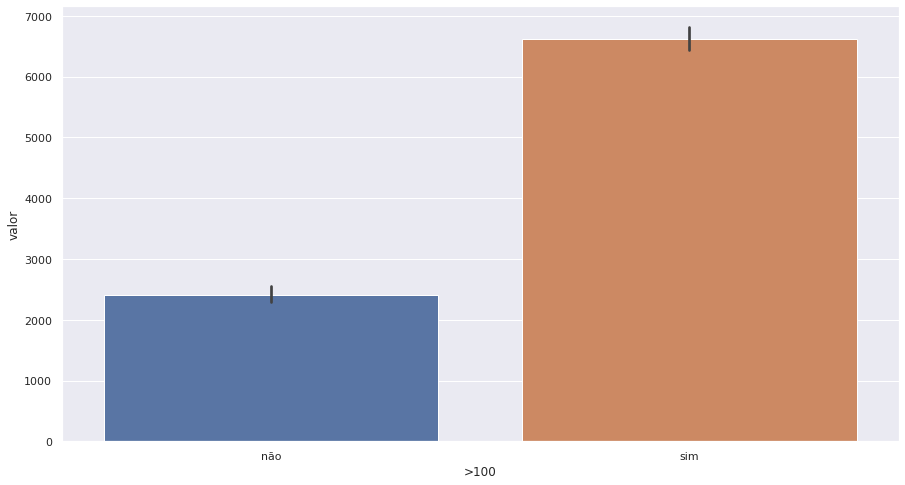

In [120]:
h1 = df4[['area', 'valor']].groupby('area').mean().reset_index()
h1['>100'] = h1['area'].apply(lambda x: 'sim' if x > 100 else 'não')

h1_aux = ((df1[df1['area'] > 100 ]['valor'].mean() / df1[df1['area'] < 100 ]['valor'].mean()) - 1) * 100

sns.barplot(x='>100', y='valor', data=h1)
print ('Hipotese Verdadeira, imoveis com mais de 100m² custa na media {:.2f}% a mais do que imovel abaixo de 100m.'.format(h1_aux));

- H2: Imoveis com 2 ou mais vagas de Estacionamento custa 40% mais na media do que imovel com 1 vaga.

Hipotese Verdadeira, imoveis com mais de 1 vagas de estacionamento custa na media 75.60% a mais do que imoveis com 1 vaga


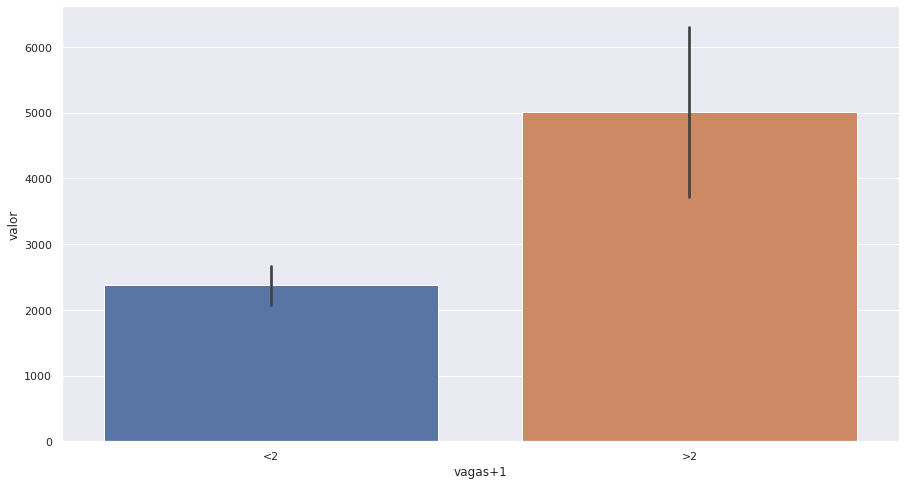

In [133]:
h2 = df4[['vagas', 'valor']].groupby('vagas').mean().reset_index()
h2['vagas+1'] = h2['vagas'].apply(lambda x: '>2' if x >= 2 else '<2' )
h2_aux = ((df4[df4['vagas'] >= 2]['valor'].mean() / df4[df4['vagas'] == 1]['valor'].mean()) - 1) * 100

sns.barplot(x='vagas+1', y='valor', data=h2);
print ('Hipotese Verdadeira, imoveis com mais de 1 vagas de estacionamento custa na media {:.2f}% a mais do que imoveis com 1 vaga'.format(h2_aux))

- H3: Imoveis que possui mais de 1 suite são 20% mais caro na media do que imovel com 1 suites.

Hipotese Verdadeira, imoveis que possui mais de uma suite, são na media 68.19% mais caro que imoveis com 1 suite


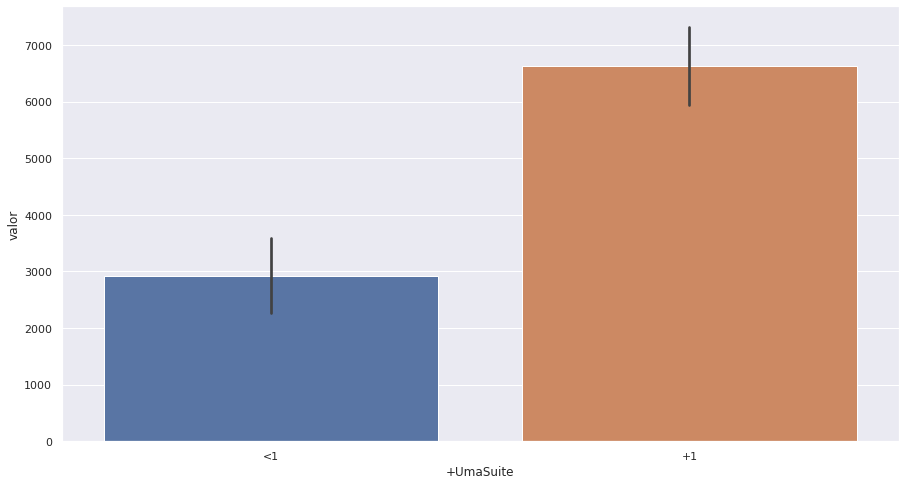

In [130]:
h3 = df4[['suites', 'valor']].groupby('suites').mean().reset_index()
h3['+UmaSuite'] = h3['suites'].apply(lambda x: '+1' if x > 1 else '<1')
h3_aux = ((df4[df4['suites'] > 1]['valor'].mean() / df4[df4['suites'] == 1]['valor'].mean()) - 1) * 100

sns.barplot(x='+UmaSuite', y='valor', data=h3);
print ('Hipotese Verdadeira, imoveis que possui mais de uma suite, são na media {:.2f}% mais caro que imoveis com 1 suite'.format(h3_aux))

- H4: Imoveis com preço abaixo da media do bairro seria uma boa oportunidade de aluguel.

                 status  valor
0          Oportunidade  13730
1  Preco acima da media  15148


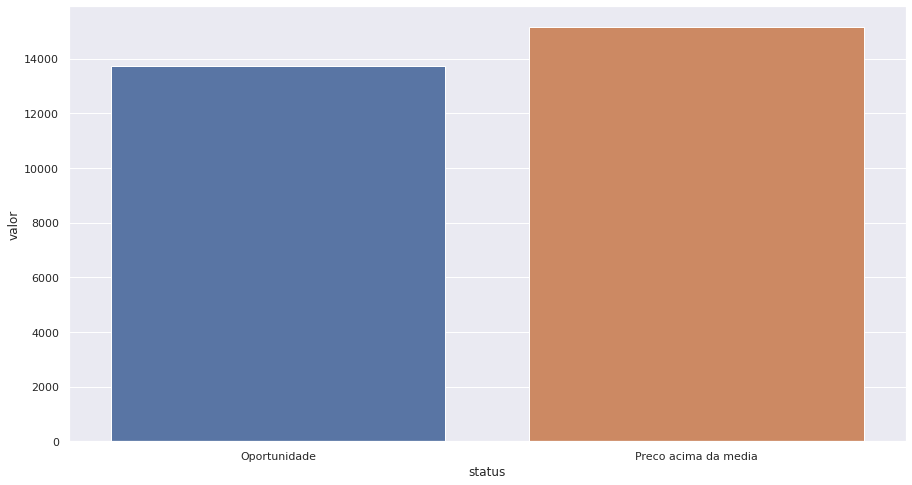

In [138]:
media_bairro = df4[['valor', 'bairro']].groupby('bairro').median().reset_index()
media_bairro.rename(columns={'valor':'Valor_medio'}, inplace=True)
h4= pd.merge(df4, media_bairro, on='bairro', how='left')

h4['status'] = 0

for i in range(len(h4)):
    if (h4.loc[i, 'Valor_medio'] > h4.loc[i, 'valor']):
        h4.loc[i, 'status'] = 'Oportunidade'
    else:
        h4.loc[i, 'status'] = 'Preco acima da media'

h4 = h4[['valor', 'status']].groupby('status').count().reset_index()

print(h4)
sns.barplot(x='status', y='valor', data=h4);

Neste caso teriamos 13.730 imoveis com preço abaixo da media região e poderia ser uma oportunidade de preço na locação.

### Analise Multivarida

#### Numerical Attribute

In [459]:
df4

,valor,area,quartos,suites,vagas,bairro_id,bairro,cidade,tipo,subtipo,id
0,1600,57.000,2,0,1,1,VL DA SAUDE,Sao Paulo,1,3,9165861
1,5600,143.000,4,1,2,2,ITAIM BIBI,Sao Paulo,1,3,8657016
2,3000,140.000,3,1,1,3,BROOKLIN,Sao Paulo,1,2,9245580
3,4000,70.000,2,1,1,4,CAMPO BELO,Sao Paulo,1,2,8788916
4,2500,80.000,2,1,2,5,PERDIZES,Sao Paulo,1,1,9257792
...,...,...,...,...,...,...,...,...,...,...,...
28873,1800,70.000,2,1,1,327,VL POLOPOLI,Sao Paulo,1,2,9645207
28874,1200,60.000,2,0,1,130,VL BUTANTÃ,Sao Paulo,1,4,9645215
28875,2600,90.000,3,1,2,99,TUCURUVI,Sao Paulo,1,2,7727709
28876,2200,82.000,3,1,1,95,VL SÔNIA,Sao Paulo,1,2,9645107


<AxesSubplot:>

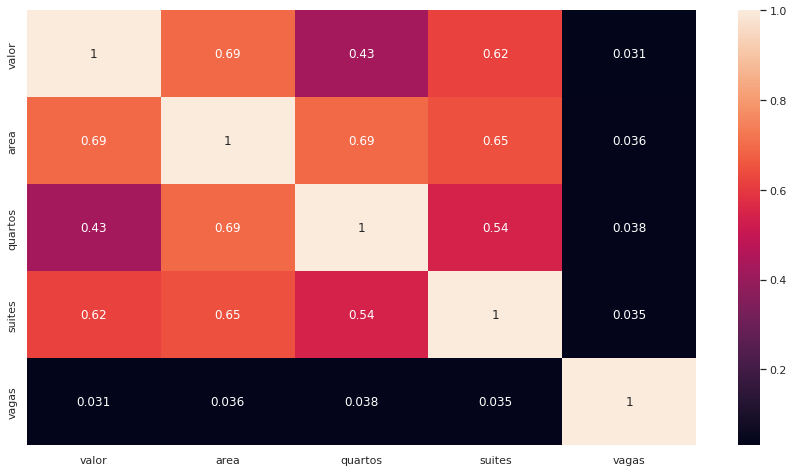

In [460]:
corre = df4[['valor', 'area', 'quartos', 'suites', 'vagas']]

correlation = corre.corr(method='pearson')
sns.heatmap(correlation, annot=True)

## Data preparatiom

In [326]:
df5 = df4[['valor', 'area', 'quartos', 'suites', 'vagas', 'bairro_id', 'id']]

df5.head()

,valor,area,quartos,suites,vagas,bairro_id,id
0,1600,57.000,2,0,1,1,9165861
1,5600,143.000,4,1,2,2,8657016
2,3000,140.000,3,1,1,3,9245580
3,4000,70.000,2,1,1,4,8788916
4,2500,80.000,2,1,2,5,9257792


In [327]:
rs= RobustScaler()
mms= MinMaxScaler()

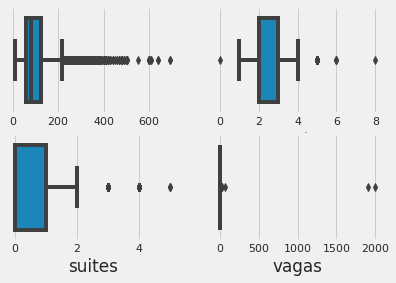

In [328]:
plt.subplot(2, 2,1)
sns.boxplot(df5['area']);

plt.subplot(2, 2,2)
sns.boxplot(df5['quartos']);

plt.subplot(2, 2,3)
sns.boxplot(df5['suites']);

plt.subplot(2, 2,4)
sns.boxplot(df5['vagas']);

Irei utilizar o Robust Scaler para rescalar os dados, pois este modelo tira a dependencia do outliers. Dependendo da peformance do modelo posso alterar para outras metricas

In [329]:
#Usando o Robust Scale para rescalar os dados

df5['area'] = rs.fit_transform(df5[['area']].values)
df5['quartos'] = rs.fit_transform(df5[['quartos']].values)
df5['suites'] = rs.fit_transform(df5[['suites']].values)
df5['vagas'] = rs.fit_transform(df5[['vagas']].values)

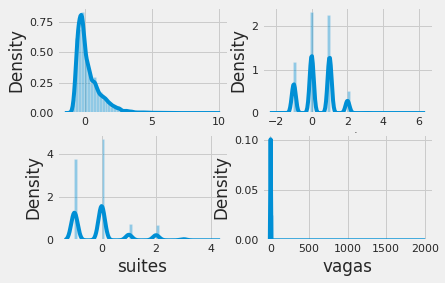

In [330]:
plt.subplot(2, 2,1)
sns.distplot(df5['area']);

plt.subplot(2, 2,2)
sns.distplot(df5['quartos']);

plt.subplot(2, 2,3)
sns.distplot(df5['suites']);

plt.subplot(2, 2,4)
sns.distplot(df5['vagas']);

### Transformação

In [331]:
df5

,valor,area,quartos,suites,vagas,bairro_id,id
0,1600,-0.365,0.000,-1.000,0.000,1,9165861
1,5600,1.000,2.000,0.000,1.000,2,8657016
2,3000,0.952,1.000,0.000,0.000,3,9245580
3,4000,-0.159,0.000,0.000,0.000,4,8788916
4,2500,0.000,0.000,0.000,1.000,5,9257792
...,...,...,...,...,...,...,...
28873,1800,-0.159,0.000,0.000,0.000,327,9645207
28874,1200,-0.317,0.000,-1.000,0.000,130,9645215
28875,2600,0.159,1.000,0.000,1.000,99,7727709
28876,2200,0.032,1.000,0.000,0.000,95,9645107


### Response Variable Transformation

In [332]:
df5['valor'] = np.log1p(df5['valor'])

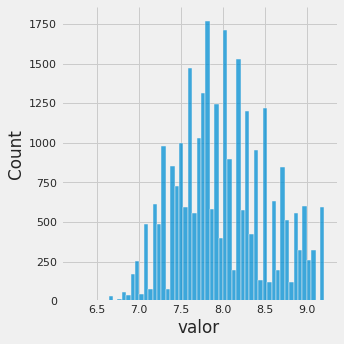

In [333]:
sns.displot(df5['valor'])

## Machine Learning Modelling

In [334]:
df6 = df5.copy()

In [335]:
X = df6.drop('valor', axis=1)
y = df6.valor

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [336]:
X_train

,area,quartos,suites,vagas,bairro_id,id
7877,0.556,1.000,0.000,1.000,10,9519900
21102,-0.079,0.000,-1.000,-1.000,51,9415814
8743,-0.492,-1.000,0.000,0.000,3,7525906
26735,1.270,1.000,2.000,2.000,17,9036781
4013,-0.667,-1.000,0.000,0.000,10,9465034
...,...,...,...,...,...,...
21575,3.111,1.000,1.000,2.000,4,9492063
5390,0.222,0.000,-1.000,1.000,96,7609539
860,0.476,0.000,-1.000,0.000,45,9089421
15795,0.841,1.000,0.000,1.000,69,9641402


In [337]:
print ('Número de linhas de X_train: {}'.format(X_train.shape))
print ('Número de linhas de X_test: {}'.format(X_test.shape))
print ('Número de linhas de y_train: {}'.format(y_train.shape))
print ('Número de linhas de y_test: {}'.format(y_test.shape))

Número de linhas de X_train: (20214, 6)
Número de linhas de X_test: (8664, 6)
Número de linhas de y_train: (20214,)
Número de linhas de y_test: (8664,)


### Definindo um Baseline

Baseline serve para termos um marco no projeto, permitindo um fácil entendimento do que precisa ser feito, sendo uma especie de referencia e tambem uma meta a ser batida pelos nossos modelos de Machine Learning

O Baseline deste projeto será a media dos valores de aluguel categorizado como 'Pequeno', 'Médio' e 'Grande' de acordo com a sua área

### Average Model

In [338]:
aux_X = df6.drop('valor', axis=1)
aux_y = df6.valor

X_train_aux, X_test_aux, y_train_aux, y_test_aux = train_test_split(aux_X, aux_y, test_size=0.3, random_state=42)

aux = X_test_aux.copy()
aux['valor'] = y_test_aux.copy()

aux1 = aux[['bairro_id', 'valor']].groupby('bairro_id').mean().reset_index().rename(columns={'valor': 'predictions'})

aux1= pd.merge(aux, aux1, on='bairro_id', how='left')

yhat_baseline = aux1['predictions']

baseline_result = ml_error('Average model', np.expm1(y_test_aux), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE,R
0,Average model,1219.993,0.348,1779.044,0.260


### Linear Regression Model

- Devido a correlação entre algumas features podemos usar uma regressão linear.
- É um modelo simples, eficiente, de solução rápida e robusta

In [339]:
lr = LinearRegression().fit(X_train, y_train)

#Prediction
yhat_lr = lr.predict(X_test)

#Performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE,R
0,Linear Regression,1048.561,0.295,1864.797,0.187


### Decision Tree

- Podemos usar também o modelo Decision Tree.
- É um algoritmo de aprendizado supervisionado.
- Simples.
- Explicabilidade do Modelo.

In [340]:
rg = DecisionTreeRegressor().fit(X_train, y_train)

yhat_rg = rg.predict(X_test)

rg_result = ml_error('Decision Tree', np.expm1(y_test), np.expm1(yhat_rg))
rg_result

,Model Name,MAE,MAPE,RMSE,R
0,Decision Tree,920.515,0.273,1452.903,0.507


### Linear Regression Regularized Model - Lasso

In [341]:
#model

lrr = Lasso(alpha=0.0001).fit(X_train, y_train)

#Prediction
yhat_lrr = lrr.predict(X_test)

#Performance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE,R
0,Linear Regression - Lasso,1048.428,0.295,1862.978,0.189


### Random Forest Regressor

In [342]:
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(X_train, y_train)

#Prediction
yhat_rf = rf.predict(X_test)

#Performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE,R
0,Random Forest Regressor,708.155,0.203,1086.555,0.724


### XGBoost Regressor

In [343]:
#model

model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                                n_estimators=100,
                                eta=0.01,
                                max_depth=15,
                                subsample=0.7,
                                colsample_bytree=0.9 ).fit(X_train, y_train)

#Prediction
yhat_xgb = model_xgb.predict(X_test)

#Performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

[20:57:14] WARNING: ../src/learner.cc:627: 
Parameters: { "colsample_bytee" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




,Model Name,MAE,MAPE,RMSE,R
0,XGBoost Regressor,3297.305,0.932,3870.943,-2.503


### Compare Model's Performance

In [344]:
modelling_result = pd.concat([baseline_result,rg_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE,R
0,Random Forest Regressor,708.155,0.203,1086.555,0.724
0,Decision Tree,920.515,0.273,1452.903,0.507
0,Average model,1219.993,0.348,1779.044,0.260
0,Linear Regression - Lasso,1048.428,0.295,1862.978,0.189
0,Linear Regression,1048.561,0.295,1864.797,0.187
0,XGBoost Regressor,3297.305,0.932,3870.943,-2.503


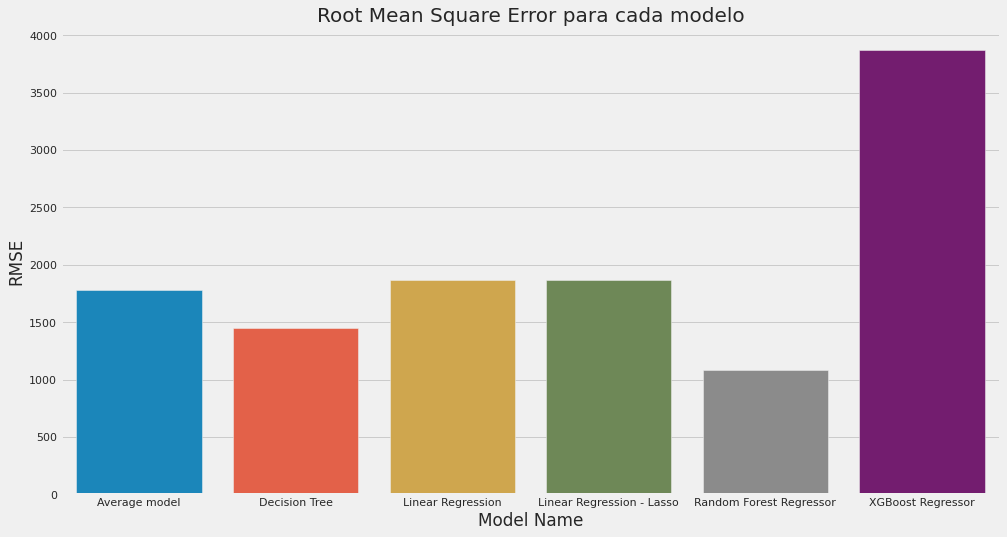

In [345]:
plt.figure(figsize=(15, 8))

sns.barplot(x='Model Name', y='RMSE', data=modelling_result)
plt.title('Root Mean Square Error para cada modelo', fontsize=20);

### Hyperparameter Fine Tuning

In [165]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)


{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [346]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()

# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(
    estimator = rf, 
    param_distributions = random_grid, 
    n_iter = 100, 
    cv = 5, 
    verbose=2, 
    random_state=42, 
    n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   6.2s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   6.4s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   6.4s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   6.7s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   7.0s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=  17.2s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; 

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

## Avaliando a performance final

In [347]:
yhat_random_tuning = rf_random.predict(X_test)

ramdom_result = ml_error('RandomForestRegressor', np.expm1(y_test), np.expm1(yhat_random_tuning))
ramdom_result

,Model Name,MAE,MAPE,RMSE,R
0,RandomForestRegressor,706.792,0.202,1080.826,0.727


## Calculating the o MPE (Checking if the model is underestimaten or overestimated)

In [369]:
mpe = np.mean((np.expm1(y_test) - np.expm1(yhat_random_tuning)) / np.expm1(y_test))

mpe = pd.DataFrame({'Model Name': 'MPE', 'MPE': mpe}, index=[0])
mpe

,Model Name,MPE
0,MPE,-0.032


- Neste caso com o MPE negativo, siginifica que a previsão é maior do que o valor real (y - yhat) neste caso o modelo esta superestimando.
- Temos uma previsão de preço na media maior do que o valor real.

## Business Performance

In [349]:
df7 = X_test

df7['valor'] = np.expm1(y_test)
df7['Predictions'] = np.expm1(yhat_random_tuning)
df7.head()

,area,quartos,suites,vagas,bairro_id,id,valor,Predictions
9443,-0.032,0.000,-1.000,0.000,10,9450636,3850.000,2512.189
10373,-0.476,-1.000,0.000,0.000,57,9105877,2700.000,2415.005
1190,1.587,0.000,1.000,1.000,45,5325620,10000.000,7190.247
1598,1.603,1.000,2.000,3.000,17,7799517,3500.000,6252.768
9539,-0.222,-1.000,-1.000,0.000,54,7639136,1800.000,1928.407


In [356]:
#Sum os predictions
df8 = df7[['id', 'Predictions']].groupby('id').sum().reset_index()

#MAE and MAPE por Imovel
df8_aux = df7[['id', 'valor', 'Predictions']].groupby('id').apply(lambda x: metrics.mean_absolute_error(x['valor'], x['Predictions'])).reset_index().rename(columns={0:'MAE'})

df8_aux1 = df7[['id', 'valor', 'Predictions']].groupby('id').apply(lambda x: metrics.mean_absolute_percentage_error(x['valor'], x['Predictions'])).reset_index().rename(columns={0:'MAPE'})

df9 = pd.merge(df8_aux, df8_aux1, how='inner', on='id')

df_final = pd.merge(df8, df9, how='inner', on='id')

#Scenarios (Criando o pior e melhor cenario)

df_final['pior_cenario'] = df_final['Predictions'] - df_final['MAE']
df_final['Melhor_cenario'] = df_final['Predictions'] + df_final['MAE']

#Organizando

df_final = df_final[['id', 'Predictions', 'pior_cenario', 'Melhor_cenario', 'MAE', 'MAPE']]


In [357]:
df_final

,id,Predictions,pior_cenario,Melhor_cenario,MAE,MAPE
0,154074,1058.092,916.185,1200.000,141.908,0.118
1,154075,1018.730,787.461,1250.000,231.270,0.185
2,154079,3352.189,1700.000,5004.378,1652.189,0.972
3,154125,1711.586,1523.172,1900.000,188.414,0.099
4,154139,1484.923,1300.000,1669.846,184.923,0.142
...,...,...,...,...,...,...
8659,9645138,1644.054,1000.000,2288.107,644.054,0.644
8660,9645150,1722.168,1620.000,1824.337,102.168,0.063
8661,9645159,4696.059,4000.000,5392.117,696.059,0.174
8662,9645207,2016.751,1800.000,2233.502,216.751,0.120


In [358]:
#Imoveis como o MAPE mais proximo de 0%
df_final.sort_values('MAPE').head()

,id,Predictions,pior_cenario,Melhor_cenario,MAE,MAPE
8201,9607844,2600.011,2600.000,2600.022,0.011,0.000
4894,9035423,2100.038,2100.000,2100.076,0.038,0.000
6046,9288300,3399.866,3399.731,3400.000,0.134,0.000
7249,9467925,2499.885,2499.770,2500.000,0.115,0.000
3798,8752416,5999.381,5999.000,5999.762,0.381,0.000


In [360]:
#Imoveis como o MAPE mais proximo de 0%
df_final.sort_values('MAPE', ascending=False).head()

,id,Predictions,pior_cenario,Melhor_cenario,MAE,MAPE
70,1815789,3779.222,950.000,6608.443,2829.222,2.978
6138,9311617,1829.986,500.000,3159.972,1329.986,2.660
7091,9444218,3732.015,1200.000,6264.030,2532.015,2.110
186,3297062,2966.031,1000.000,4932.061,1966.031,1.966
215,3746541,7189.006,2500.000,11878.012,4689.006,1.876


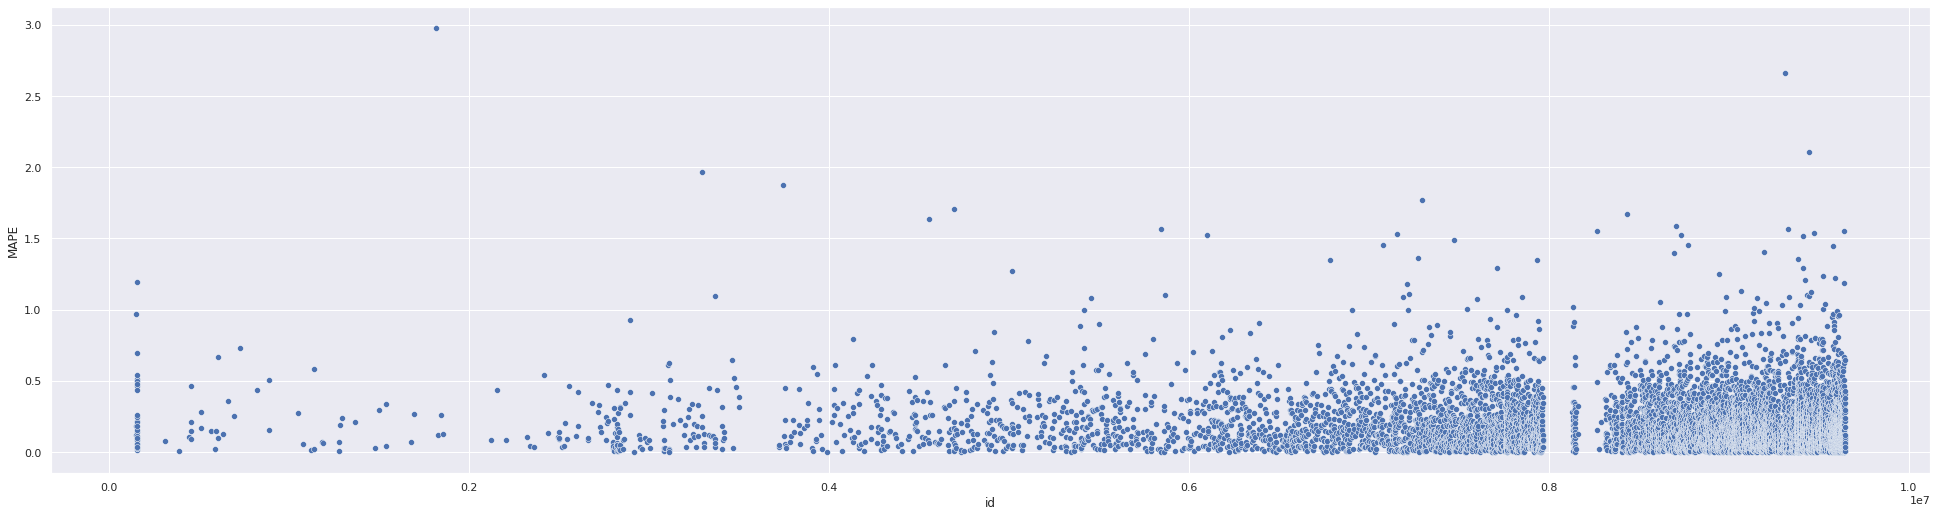

In [372]:
sns.set(rc = {'figure.figsize': (30, 8)})
sns.scatterplot(x='id', y='MAPE', data= df_final);

### Performance

In [375]:
# total performance
df_total = df_final[['Predictions', 'pior_cenario', 'Melhor_cenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index': 'Scenario', 0:'values'})

df_total['values'] = df_total['values'].map('R${:,.2f}'.format)
df_total

,Scenario,values
0,Predictions,"R$29,135,948.76"
1,pior_cenario,"R$23,012,305.88"
2,Melhor_cenario,"R$35,259,591.63"


### Graficos da Performance do modelo

In [377]:
#Diferença do erro
df7['error'] = df7['valor'] - df7['Predictions']
df7['error_rate'] = df7['Predictions'] / df7['valor']

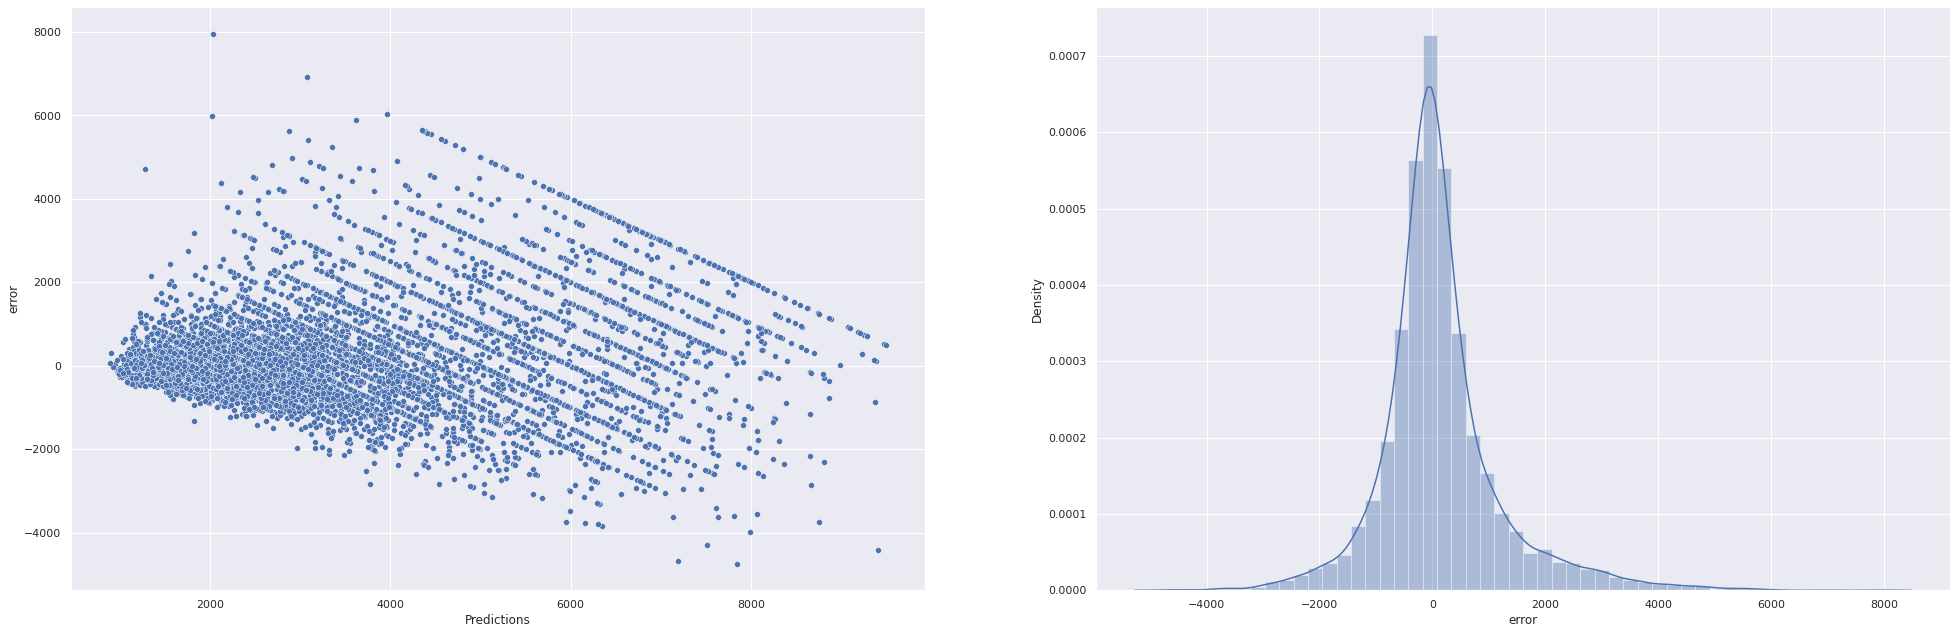

In [384]:
sns.set(rc = {'figure.figsize':(30,10)})

# O erro precisa ficar dentro de um tubo (Analise de residuo)
plt.subplot(1,2,1)
sns.scatterplot(df7['Predictions'], df7['error'])

#Grafico da distribuição do erro
plt.subplot(1,2,2)
sns.distplot(df7['error']);